In [1]:
pip install git+https://github.com/akanametov/transform.git#egg=transform

  Cloning https://github.com/akanametov/transform.git to /tmp/pip-install-rzttdv8n/transform
  Running command git clone -q https://github.com/akanametov/transform.git /tmp/pip-install-rzttdv8n/transform
  Created wheel for transform: filename=transform-1.0-cp37-none-any.whl size=3593 sha256=c34f92de6ddbec8b6bc8e39acce01d6d63694d173a1a04407ed365bf623c5a13
  Stored in directory: /tmp/pip-ephem-wheel-cache-tb9gwbb7/wheels/ef/ae/59/ec0f969c3631a44466e672c1025e09f9d67e17b508d97bc3ab
Successfully built transform


In [1]:
import os
import re
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

import torch
from torch.utils.data import Dataset, DataLoader
import transform as T

### Helper functions

In [2]:
def read_bbox(path):
    d = re.compile('\d+')
    with open(path, 'r') as f:
        data = f.readlines()
    bboxes = [list(map(int, d.findall(box))) for box in data]
    bboxes = [box for box in bboxes if len(box)==5]
    try:
        bboxes = [bbox for bbox in bboxes if bbox[-1]==1]
    except IndexError:
        print(data)
    return bboxes

def draw_bbox(img, bbox):
    thickness = 2
    color = (0, 255, 0)
    img = img.copy()
    for box in bbox:
        x1, y1, x2, y2, cls_id = box
        draw = ImageDraw.Draw(img)
        for k in range(thickness):
            draw.rectangle([x1+k, y1+k, x2-k, y2-k], outline=color)
        del draw
    return img

### Define Dataset

In [3]:
class AircraftDataset(Dataset):
    def __init__(self, img_path, bbox_path, transform):
        self.img_path=img_path
        self.bbox_path=bbox_path
        self.transform=transform
        
    def __len__(self,):
        return len(self.img_path)
    
    def __getitem__(self, idx):
        fname = self.img_path[idx]
        img = Image.open(fname).convert('RGB')
        W, H = img.size
        img_name = fname.split('/')[-1].split('.')[0]
        bbox = read_bbox(f'{self.bbox_path}/{img_name}.txt') 
        
        if len(bbox)==0:
            bbox=[[0, 0, W, H, 0]]

        img, bbox = self.transform(img, bbox)
        num_box = bbox.argmin(dim=0)[0]
        return img, bbox, num_box

### Load sample

In [5]:
img = Image.open('sample_data/002.jpg').convert('RGB')
bbox = read_bbox('sample_data/002.txt')

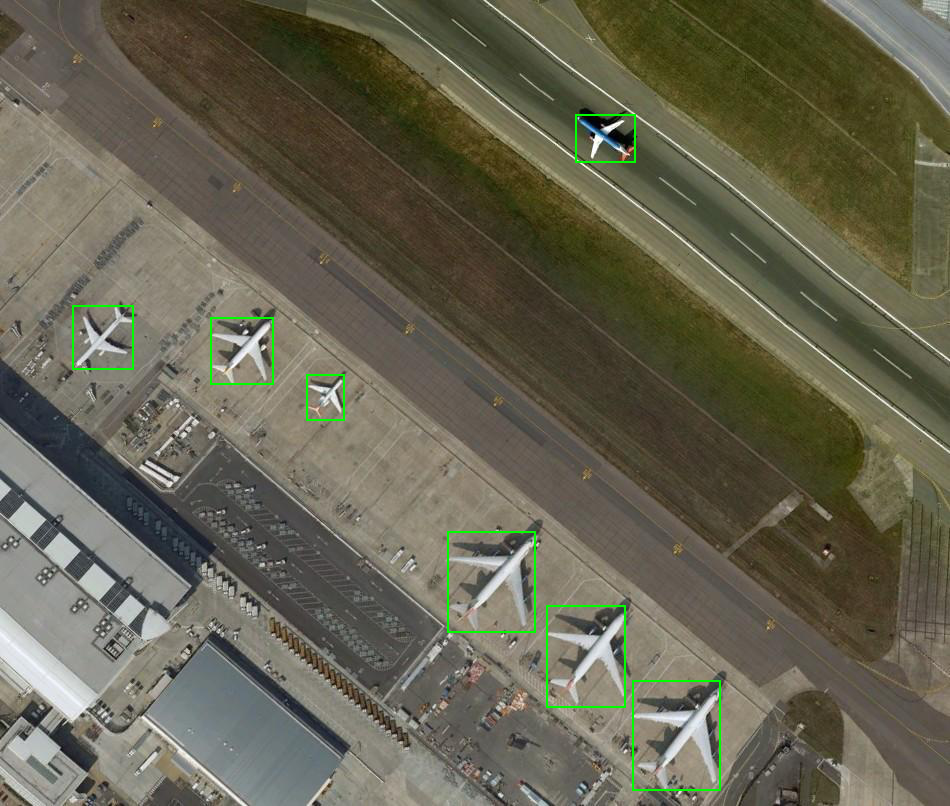

In [6]:
draw_bbox(img, bbox)

### All transforms

**Resize()**

In [10]:
size = (416,416)
resize = T.Resize(size)

img_resized, bbox_resized = resize(img, bbox)

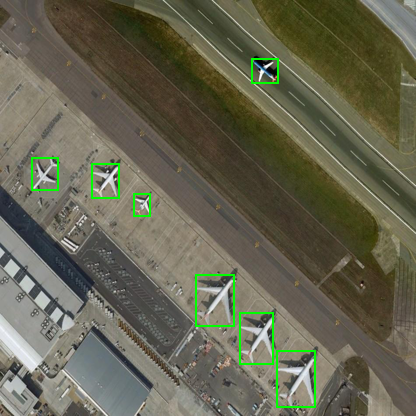

In [11]:
draw_bbox(img_resized, bbox_resized)

**Rotate()**

In [12]:
p = 1
rotate = T.Rotate(p)

img_rot, bbox_rot = rotate(img_resized, bbox_resized)

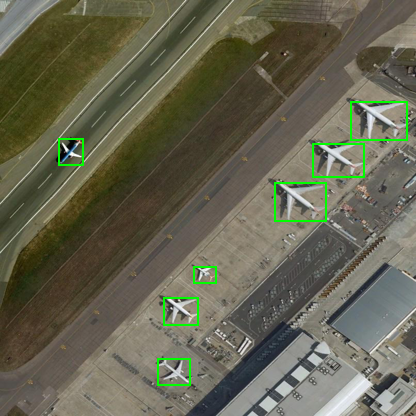

In [13]:
draw_bbox(img_rot, bbox_rot)

**HorizontalFlip()**

In [14]:
p = 1
horizontal_flip = T.HorizontalFlip(p)

img_hflip, bbox_hflip = horizontal_flip(img_rot, bbox_rot)

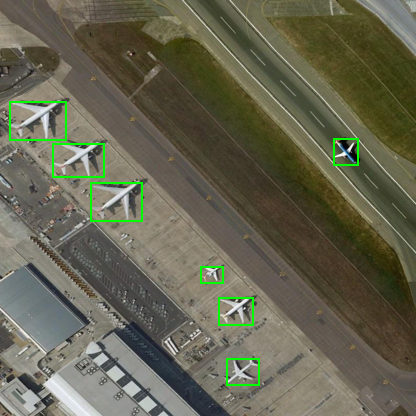

In [15]:
draw_bbox(img_hflip, bbox_hflip)

**VerticalFlip()**

In [16]:
p = 1
vertical_flip = T.VerticalFlip(p)

img_vflip, bbox_vflip = vertical_flip(img_hflip, bbox_hflip)

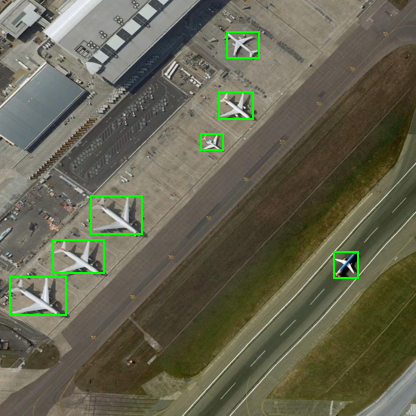

In [17]:
draw_bbox(img_vflip, bbox_vflip)

**ToTensor()**

In [18]:
to_tensor = T.ToTensor()

img_torch, bbox_torch = to_tensor(img_vflip, bbox_vflip)

In [19]:
print('image shape:', img_torch.shape)
print('bbox shape:', bbox_torch.shape)

image shape: torch.Size([3, 416, 416])
bbox shape: torch.Size([7, 5])


In [20]:
print('min value:', img_torch.min().item())
print('max value:', img_torch.max().item())

min value: 0.0
max value: 1.0


In [48]:
img_torch

tensor([[[0.5569, 0.5373, 0.4588,  ..., 0.3882, 0.3843, 0.3725],
         [0.5451, 0.4784, 0.3137,  ..., 0.3765, 0.3765, 0.3804],
         [0.4863, 0.5137, 0.4627,  ..., 0.3765, 0.3765, 0.3804],
         ...,
         [0.3922, 0.3922, 0.3922,  ..., 0.6549, 0.6863, 0.6431],
         [0.3961, 0.3961, 0.3961,  ..., 0.6392, 0.6510, 0.6314],
         [0.4000, 0.4000, 0.4000,  ..., 0.5412, 0.5529, 0.5647]],

        [[0.5294, 0.5098, 0.4314,  ..., 0.3529, 0.3490, 0.3373],
         [0.5098, 0.4392, 0.2745,  ..., 0.3412, 0.3412, 0.3451],
         [0.4314, 0.4588, 0.4039,  ..., 0.3412, 0.3412, 0.3451],
         ...,
         [0.3412, 0.3412, 0.3412,  ..., 0.6863, 0.7137, 0.6706],
         [0.3451, 0.3451, 0.3451,  ..., 0.6706, 0.6784, 0.6588],
         [0.3490, 0.3490, 0.3490,  ..., 0.5725, 0.5804, 0.5922]],

        [[0.4863, 0.4667, 0.3843,  ..., 0.3255, 0.3294, 0.3176],
         [0.4588, 0.3961, 0.2314,  ..., 0.3176, 0.3216, 0.3255],
         [0.3804, 0.4078, 0.3490,  ..., 0.3137, 0.3216, 0.

In [21]:
bbox_torch

tensor([[333, 251, 358, 278,   1],
        [226,  31, 259,  58,   1],
        [218,  91, 253, 119,   1],
        [200, 133, 223, 150,   1],
        [ 90, 195, 142, 234,   1],
        [ 52, 239, 104, 273,   1],
        [  9, 276,  66, 315,   1]])

**Normalize()**

In [22]:
normalize = T.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])

img_norm, bbox_norm = normalize(img_torch, bbox_torch)

In [23]:
print('min value:', img_norm.min().item())
print('max value:', img_norm.max().item())

min value: -2.11790397275365
max value: 2.640000121858388


In [49]:
img_norm

tensor([[[ 0.3138,  0.2282, -0.1143,  ..., -0.4226, -0.4397, -0.4911],
         [ 0.2624, -0.0287, -0.7479,  ..., -0.4739, -0.4739, -0.4568],
         [ 0.0056,  0.1254, -0.0972,  ..., -0.4739, -0.4739, -0.4568],
         ...,
         [-0.4054, -0.4054, -0.4054,  ...,  0.7419,  0.8789,  0.6906],
         [-0.3883, -0.3883, -0.3883,  ...,  0.6734,  0.7248,  0.6392],
         [-0.3712, -0.3712, -0.3712,  ...,  0.2453,  0.2967,  0.3481]],

        [[ 0.3277,  0.2402, -0.1099,  ..., -0.4601, -0.4776, -0.5301],
         [ 0.2402, -0.0749, -0.8102,  ..., -0.5126, -0.5126, -0.4951],
         [-0.1099,  0.0126, -0.2325,  ..., -0.5126, -0.5126, -0.4951],
         ...,
         [-0.5126, -0.5126, -0.5126,  ...,  1.0280,  1.1506,  0.9580],
         [-0.4951, -0.4951, -0.4951,  ...,  0.9580,  0.9930,  0.9055],
         [-0.4776, -0.4776, -0.4776,  ...,  0.5203,  0.5553,  0.6078]],

        [[ 0.3568,  0.2696, -0.0964,  ..., -0.3578, -0.3404, -0.3927],
         [ 0.2348, -0.0441, -0.7761,  ..., -0

In [24]:
bbox_norm

tensor([[0.8005, 0.6034, 0.8606, 0.6683, 1.0000],
        [0.5433, 0.0745, 0.6226, 0.1394, 1.0000],
        [0.5240, 0.2188, 0.6082, 0.2861, 1.0000],
        [0.4808, 0.3197, 0.5361, 0.3606, 1.0000],
        [0.2163, 0.4688, 0.3413, 0.5625, 1.0000],
        [0.1250, 0.5745, 0.2500, 0.6562, 1.0000],
        [0.0216, 0.6635, 0.1587, 0.7572, 1.0000]])

**PadBBox()**

In [25]:
max_num_bbox = 10
pad_value=-1.0

padbbox = T.PadBBox(max_num_bbox, pad_value)

img_norm, bbox_pad = padbbox(img_norm, bbox_norm)

In [26]:
bbox_pad

tensor([[ 0.8005,  0.6034,  0.8606,  0.6683,  1.0000],
        [ 0.5433,  0.0745,  0.6226,  0.1394,  1.0000],
        [ 0.5240,  0.2188,  0.6082,  0.2861,  1.0000],
        [ 0.4808,  0.3197,  0.5361,  0.3606,  1.0000],
        [ 0.2163,  0.4688,  0.3413,  0.5625,  1.0000],
        [ 0.1250,  0.5745,  0.2500,  0.6562,  1.0000],
        [ 0.0216,  0.6635,  0.1587,  0.7572,  1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000]])

**DeNormalize()**

In [27]:
denormalize = T.DeNormalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])

img_denorm, bbox_denorm = denormalize(img_norm, bbox_norm)

In [28]:
print('min value:', img_denorm.min().item())
print('max value:', img_denorm.max().item())

min value: 0.0
max value: 1.0


In [50]:
img_denorm

tensor([[[0.5569, 0.5373, 0.4588,  ..., 0.3882, 0.3843, 0.3725],
         [0.5451, 0.4784, 0.3137,  ..., 0.3765, 0.3765, 0.3804],
         [0.4863, 0.5137, 0.4627,  ..., 0.3765, 0.3765, 0.3804],
         ...,
         [0.3922, 0.3922, 0.3922,  ..., 0.6549, 0.6863, 0.6431],
         [0.3961, 0.3961, 0.3961,  ..., 0.6392, 0.6510, 0.6314],
         [0.4000, 0.4000, 0.4000,  ..., 0.5412, 0.5529, 0.5647]],

        [[0.5294, 0.5098, 0.4314,  ..., 0.3529, 0.3490, 0.3373],
         [0.5098, 0.4392, 0.2745,  ..., 0.3412, 0.3412, 0.3451],
         [0.4314, 0.4588, 0.4039,  ..., 0.3412, 0.3412, 0.3451],
         ...,
         [0.3412, 0.3412, 0.3412,  ..., 0.6863, 0.7137, 0.6706],
         [0.3451, 0.3451, 0.3451,  ..., 0.6706, 0.6784, 0.6588],
         [0.3490, 0.3490, 0.3490,  ..., 0.5725, 0.5804, 0.5922]],

        [[0.4863, 0.4667, 0.3843,  ..., 0.3255, 0.3294, 0.3176],
         [0.4588, 0.3961, 0.2314,  ..., 0.3176, 0.3216, 0.3255],
         [0.3804, 0.4078, 0.3490,  ..., 0.3137, 0.3216, 0.

In [29]:
bbox_denorm

tensor([[333, 251, 358, 278,   1],
        [226,  31, 259,  58,   1],
        [218,  91, 253, 119,   1],
        [200, 133, 223, 150,   1],
        [ 90, 195, 142, 234,   1],
        [ 52, 239, 104, 273,   1],
        [  9, 276,  66, 315,   1]])

**ToImage()**

In [30]:
to_image = T.ToImage()

img_pil, bbox_list = to_image(img_denorm, bbox_denorm)

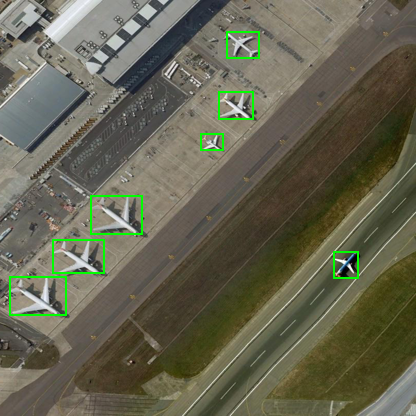

In [31]:
draw_bbox(img_pil, bbox_list)

### Apply transforms sequentially

**Transform**

In [32]:
transform = T.Compose([
                       T.Resize((416,416)),
                       T.Rotate(0.3),
                       T.HorizontalFlip(0.3),
                       T.VerticalFlip(0.3),
                       T.ToTensor(),
                       T.Normalize(
                           mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225]),
                       T.PadBBox(
                           max_num_bbox=10,
                           pad_value=-1.0
                       )
])

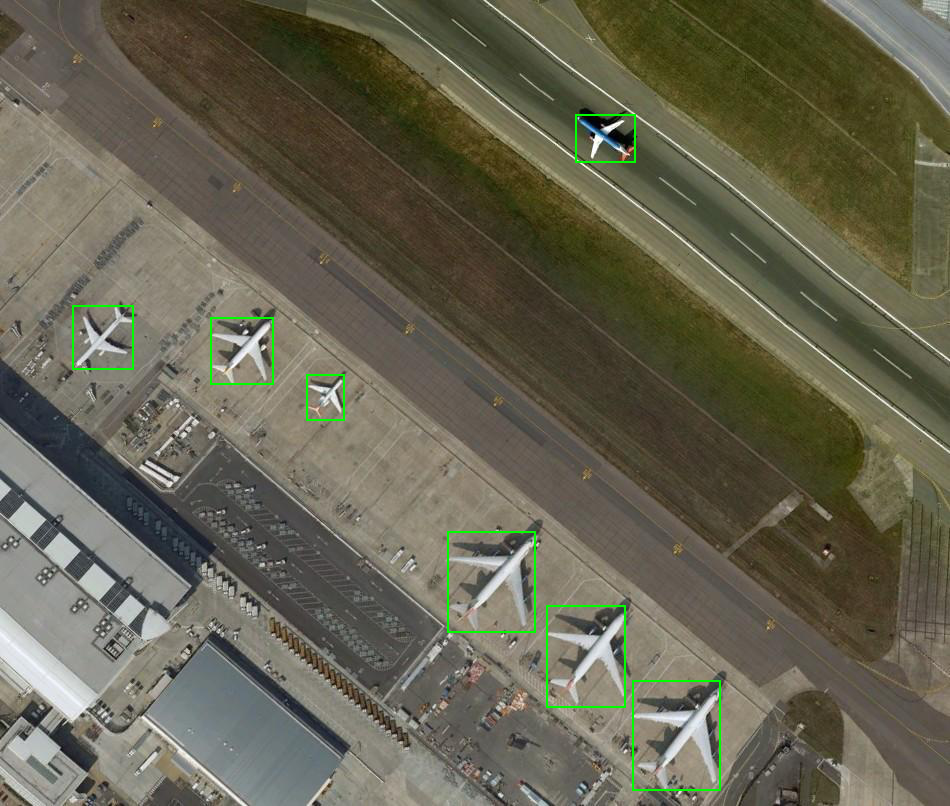

In [33]:
img = Image.open('sample_data/aircraft/002.jpg').convert('RGB')
bbox = read_bbox('sample_data/aircraft/002.txt')

draw_bbox(img, bbox)

In [41]:
transformed_img, transformed_bbox = transform(img, bbox)

In [42]:
print('image shape:', img_torch.shape)
print('bbox shape:', bbox_torch.shape)
print('min image value:', img_norm.min().item())
print('max image value:', img_norm.max().item())

image shape: torch.Size([3, 416, 416])
bbox shape: torch.Size([7, 5])
min image value: -2.11790397275365
max image value: 2.640000121858388


In [43]:
transformed_bbox

tensor([[ 0.3317,  0.1394,  0.3966,  0.1995,  1.0000],
        [ 0.8606,  0.3774,  0.9255,  0.4567,  1.0000],
        [ 0.7139,  0.3918,  0.7812,  0.4760,  1.0000],
        [ 0.6394,  0.4639,  0.6803,  0.5192,  1.0000],
        [ 0.4375,  0.6587,  0.5312,  0.7837,  1.0000],
        [ 0.3438,  0.7500,  0.4255,  0.8750,  1.0000],
        [ 0.2428,  0.8413,  0.3365,  0.9784,  1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000]])

**DeTransform**

In [44]:
detransform = T.Compose([
                         T.DeNormalize(
                           mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225]),
                         T.ToImage()
])

In [45]:
num_bbox = transformed_bbox.argmin(dim=0)[0]
print(num_bbox)

tensor(7)


In [46]:
detransformed_img, detransformed_bbox = detransform(transformed_img, transformed_bbox[:num_bbox])

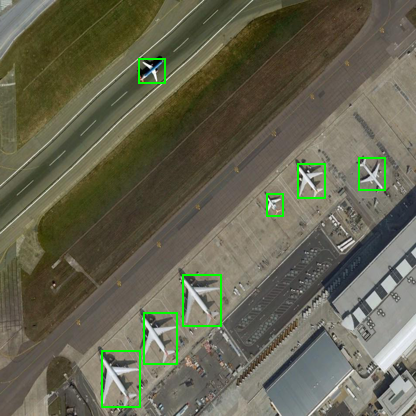

In [47]:
draw_bbox(detransformed_img, detransformed_bbox)